Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15 

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31 

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166 

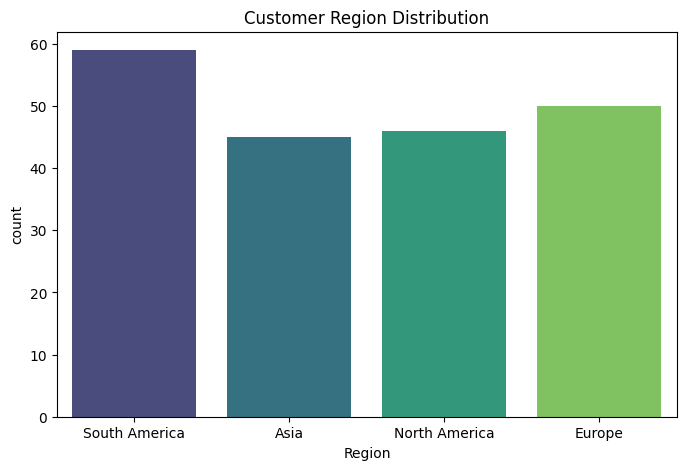

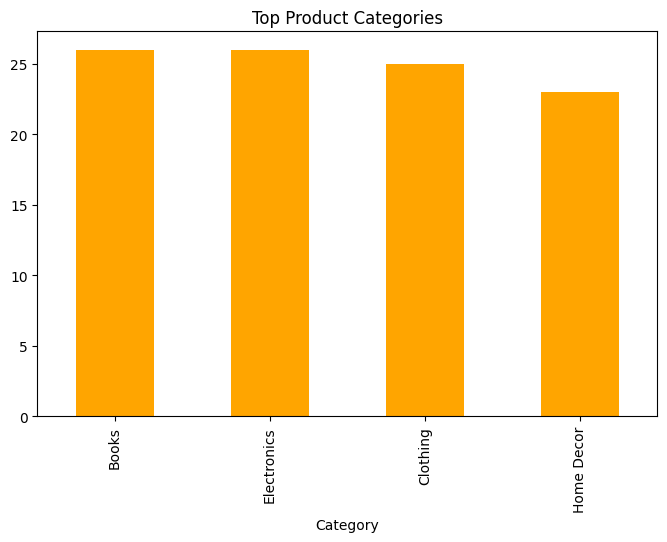

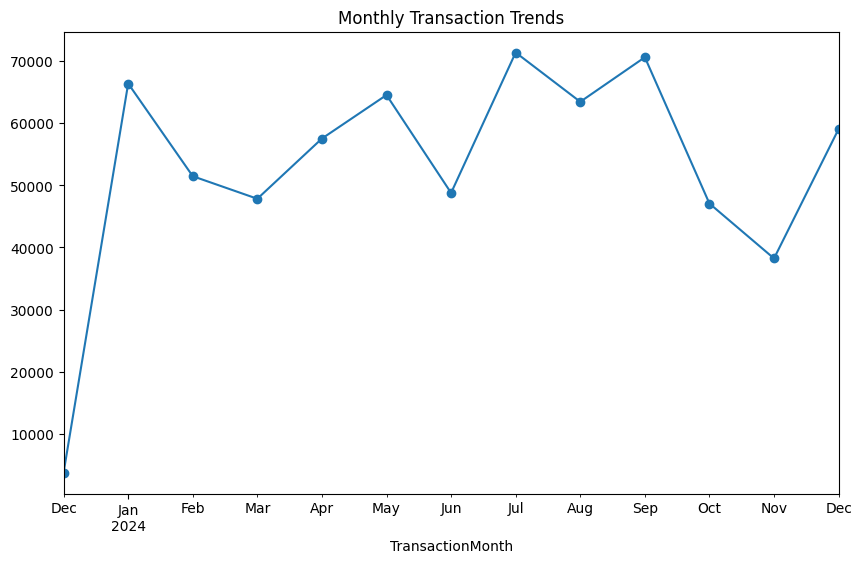

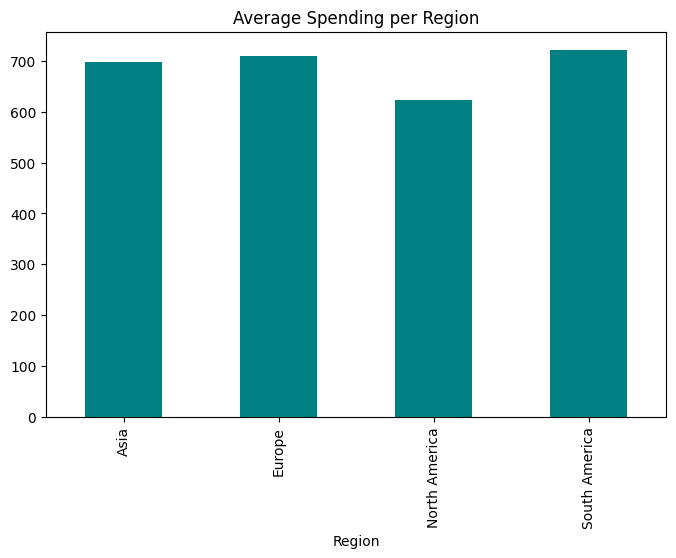

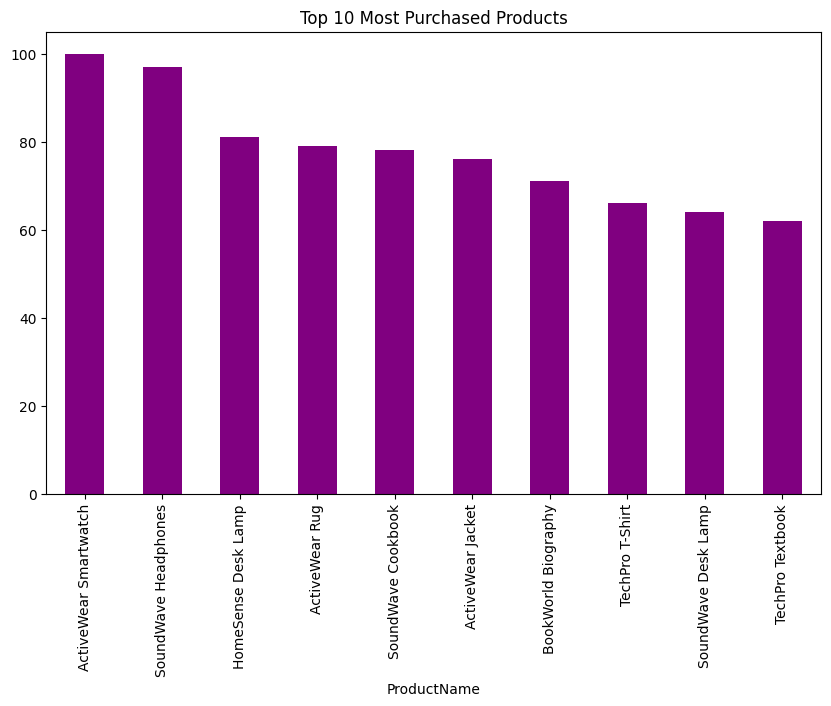

Davies-Bouldin Index: 0.7529350579420507


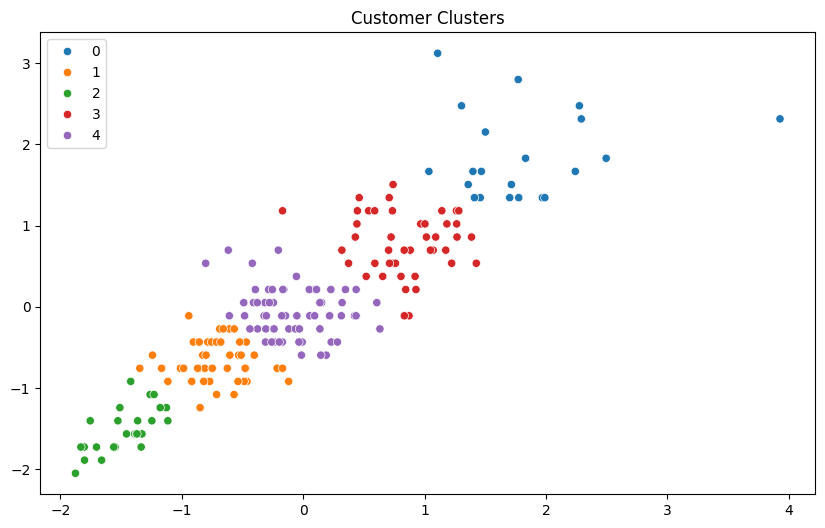

Files saved successfully:
Lookalike Results: C:\Users\chand\OneDrive\Desktop\Jupyter Projects\Bhupesh_Chandra_Lookalike.csv
Customer Clusters: C:\Users\chand\OneDrive\Desktop\Jupyter Projects\Bhupesh_Chandra_CustomerClusters.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import os

# Define base path
base_path = r'C:\Users\chand\OneDrive\Desktop\Jupyter Projects'

# File paths
customers_file = os.path.join(base_path, 'Customers.csv')
products_file = os.path.join(base_path, 'Products.csv')
transactions_file = os.path.join(base_path, 'Transactions.csv')

# Check if files exist
if not os.path.exists(customers_file):
    raise FileNotFoundError(f"File not found: {customers_file}")
if not os.path.exists(products_file):
    raise FileNotFoundError(f"File not found: {products_file}")
if not os.path.exists(transactions_file):
    raise FileNotFoundError(f"File not found: {transactions_file}")

# Load datasets
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

# Preview datasets
print("Customers Dataset:")
print(customers.head(), "\n")
print("Products Dataset:")
print(products.head(), "\n")
print("Transactions Dataset:")
print(transactions.head(), "\n")

# Data Cleaning
# Check for missing values
print("Missing Values:")
print("Customers:", customers.isnull().sum(), "\n")
print("Products:", products.isnull().sum(), "\n")
print("Transactions:", transactions.isnull().sum(), "\n")

# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Descriptive Statistics
print("Customers Statistics:")
print(customers.describe(include='all'), "\n")
print("Products Statistics:")
print(products.describe(include='all'), "\n")
print("Transactions Statistics:")
print(transactions.describe(include='all'), "\n")

# EDA
# 1. Customer Region Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=customers, x='Region', hue='Region', palette='viridis', dodge=False, legend=False)
plt.title('Customer Region Distribution')
plt.show()

# 2. Top Product Categories
top_categories = products['Category'].value_counts()
plt.figure(figsize=(8, 5))
top_categories.plot(kind='bar', color='orange')
plt.title('Top Product Categories')
plt.show()

# 3. Transaction Trends Over Time
transactions['TransactionMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_transactions = transactions.groupby('TransactionMonth')['TotalValue'].sum()
plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Monthly Transaction Trends')
plt.show()

# 4. Average Spending per Region
region_spending = transactions.merge(customers, on='CustomerID').groupby('Region')['TotalValue'].mean()
plt.figure(figsize=(8, 5))
region_spending.plot(kind='bar', color='teal')
plt.title('Average Spending per Region')
plt.show()

# 5. Most Purchased Products
most_purchased = transactions.merge(products, on='ProductID').groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
most_purchased.plot(kind='bar', color='purple')
plt.title('Top 10 Most Purchased Products')
plt.show()

# Task 2: Lookalike Model
# Prepare data for similarity calculation
customer_transactions = transactions.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
customer_profiles = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)
customer_product_matrix = transactions.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

# Calculate similarity scores
similarity_matrix = cosine_similarity(customer_product_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

# Get top 3 similar customers for each of the first 20 customers
lookalike_results = {}
for customer_id in customer_profiles['CustomerID'][:20]:
    similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False)[1:4]
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Task 3: Customer Segmentation
# Merge customer and transaction data
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Scale data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
customer_data['Cluster'] = clusters

# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=clusters, palette='tab10')
plt.title('Customer Clusters')
plt.show()

# Save Lookalike results and Clusters to CSV
lookalike_rows = []
for cust_id, similarities in lookalike_results.items():
    row = {"CustomerID": cust_id}
    for i, (sim_id, score) in enumerate(similarities, start=1):
        row[f"SimilarCustomer{i}"] = sim_id
        row[f"Score{i}"] = score
    lookalike_rows.append(row)

lookalike_df = pd.DataFrame(lookalike_rows)
lookalike_output_file = os.path.join(base_path, 'Bhupesh_Chandra_Lookalike.csv')
lookalike_df.to_csv(lookalike_output_file, index=False)

customer_cluster_output_file = os.path.join(base_path, 'Bhupesh_Chandra_CustomerClusters.csv')
customer_data.to_csv(customer_cluster_output_file, index=False)

print(f"Files saved successfully:\nLookalike Results: {lookalike_output_file}\nCustomer Clusters: {customer_cluster_output_file}")